In [1]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END

from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)

from langgraph.checkpoint.memory import MemorySaver

from langchain_core.output_parsers import JsonOutputParser

from typing_extensions import TypedDict


#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from pydantic import BaseModel, Field
import os


from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal, Optional


#getting current location
import geocoder
import os
import requests
import json
from dotenv import load_dotenv 
from os import listdir
from os.path import isfile, join
load_dotenv()



c:\Users\padio\Desktop\important\AI portfolio\Travel-assistant\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
GOOGLE_API_KEY=os.getenv('google_api_key')

In [3]:
GEMINI_MODEL='gemini-1.5-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [4]:
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  node_message: str
  query: str
  #location data
  latitude: str
  longitude: str
  address: str
  place_query: str
  #results from place search
  places: dict
  route:str

In [ ]:
def get_current_location_node(state: State):
    """
    Tool to get the current location of the user.
    agrs: none
    """
    current_location = geocoder.ip("me")
    if current_location.latlng:
        latitude, longitude = current_location.latlng
        address = current_location.address
        return {
            'latitude':latitude,
            'longitude':longitude,
            'address':address,
            'node_message':{'latitude':latitude,
            'longitude':longitude,
            'address':address}}
    else:
        return {'node_message':'failed'}

In [6]:
def router_node(state=State):
    route=state.get('route')
    if route=='look_for_places':
        return 'to_look_for_places' 
    elif route=='current_loc':
        return 'to_current_loc'

In [7]:

def look_for_places_node(state: State):
    """
    Tool to look for places based on the user query and location.
    Use this tool for more complex user queries like sentences, and if the location is specified in the query.
    Places includes restaurants, bars, speakeasy, games, anything.
    args: query - the query has to be in this format eg.Spicy%20Vegetarian%20Food%20in%20Sydney%20Australia.
    Alaways include the links in the respons, but not longitude or latitude
    """

    try:
        response=requests.get(f'https://maps.googleapis.com/maps/api/place/textsearch/json?query={state.get('place_query')}?&key={GOOGLE_API_KEY}')
        data=response.json()
        places={}
        for place in data['results']:
            try:
                name=place['name']
                rating=place['rating']
                id=place['place_id']
                price_level=place['price_level']
                address=place['formatted_address']
                lattitude=place['geometry']['location']['lat']
                longitude=place['geometry']['location']['lng']
                response=requests.get(f'https://places.googleapis.com/v1/places/{id}?fields=googleMapsLinks.placeUri&key={GOOGLE_API_KEY}')
                data=response.json()
                link=data['googleMapsLinks']['placeUri']
                places[name]= {'address': address,
                                'rating':rating,
                                'Price_level':price_level,
                                'google_maps_link':link,
                                'longitude':longitude,
                                'latitude':lattitude}
            except Exception as e:
                f'Error: {e}'
                
        return {'places':places,
                'node_message':places}
    except Exception as e:
        return {'node_message': e}

In [ ]:
class Maps_agent:
    def __init__(self,llm: any):
        self.agent=self._setup(llm)
        

    def _setup(self,llm):
        # langgraph_tools=[get_current_location_tool,look_for_places, show_places_found]
        def agent_node(state:State):
            class Form(BaseModel):
                route: str = Field(description= 'return current_loc or look_for_places')
                place_query: Optional[str] = Field(description= ' if the query is to look for a place return the place_query has to be in this format eg.Spicy%20Vegetarian%20Food%20in%20Sydney%20Australia')
            parser=JsonOutputParser(pydantic_object=Form)
            instruction=parser.get_format_instructions()
            response=llm.invoke([HumanMessage(content=f'based on this query:{state['query']}, return current_loc to get the current location or look_for_places for the route '+'\n\n'+instruction)])
            response=parser.parse(response.content)
            route=response.get('route')
            place_query=response.get('place_query')
            return {'route':route,
                    'place_query': place_query}

        graph_builder = StateGraph(State)
        

        graph_builder.add_node('current_loc', get_current_location_node)
        graph_builder.add_node('look_for_places',look_for_places_node)
        
        graph_builder.add_node('agent',agent_node)
        graph_builder.add_edge(START,'agent')
        graph_builder.add_conditional_edges('agent',router_node,{'to_current_loc':'current_loc', 'to_look_for_places':'look_for_places'})
        graph_builder.add_edge('current_loc',END)
        graph_builder.add_edge('look_for_places',END)
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
    
    def display_graph(self):
        return display(
            Image(
                    self.agent.get_graph().draw_mermaid_png(
                        draw_method=MermaidDrawMethod.API,
                    )
                )
            )
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]
    
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input},config)
        return response.get('node_message')

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input}, config, stream_mode="updates"):
            print(event)

In [9]:
test=Maps_agent(llm)

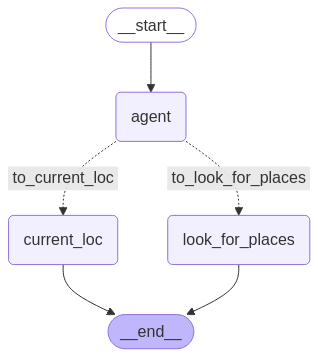

In [10]:
test.display_graph()

In [11]:
response=test.chat('find some cool cocktails bars in chelsea')

In [14]:
response.get('node_message')

{'The Tippler': {'address': '425 W 15th St, New York, NY 10011, United States',
  'rating': 4.2,
  'Price_level': 2,
  'google_maps_link': 'https://maps.google.com/?cid=64616661199206757',
  'longitude': -74.0062542,
  'latitude': 40.7423235},
 'Bathtub Gin': {'address': '132 9th Ave, New York, NY 10011, United States',
  'rating': 4.3,
  'Price_level': 3,
  'google_maps_link': 'https://maps.google.com/?cid=896988001401816655',
  'longitude': -74.0032277,
  'latitude': 40.743602},
 'Jungle Bird': {'address': '174 8th Ave, New York, NY 10011, United States',
  'rating': 4.4,
  'Price_level': 2,
  'google_maps_link': 'https://maps.google.com/?cid=9957527372034215284',
  'longitude': -74.00022419999999,
  'latitude': 40.7426188},
 'Porchlight': {'address': '271 11th Ave, New York, NY 10001, United States',
  'rating': 4.4,
  'Price_level': 3,
  'google_maps_link': 'https://maps.google.com/?cid=6606264242576959888',
  'longitude': -74.0049906,
  'latitude': 40.7520383},
 'Raines Law Room C

In [13]:
test.get_state('route')

'look_for_places'